In [1]:
import pandas as pd
import numpy as np
import pickle

In [6]:
import os

# List all files in the current directory
all_files = os.listdir('.')

# Filter files starting with "results"
files = [file for file in all_files if file.startswith('results')]
print(files)

['results-1726520874.0156014.pkl', 'results-1728997020.029273.pkl', 'results-1729369582.5604427.pkl', 'results-1729762125.611749.pkl', 'results-1730889569.5564394.pkl', 'results-1730898263.0294523.pkl', 'results-1730912740.118672.pkl', 'results-1730989228.708175.pkl', 'results-1730991269.2003536.pkl', 'results-1731021760.8238072.pkl', 'results-1731022011.970931.pkl', 'results-1731027517.8095496.pkl', 'results-1731027512.3659773.pkl', 'results-1731054939.6197686.pkl', 'results-1731054927.3674006.pkl']


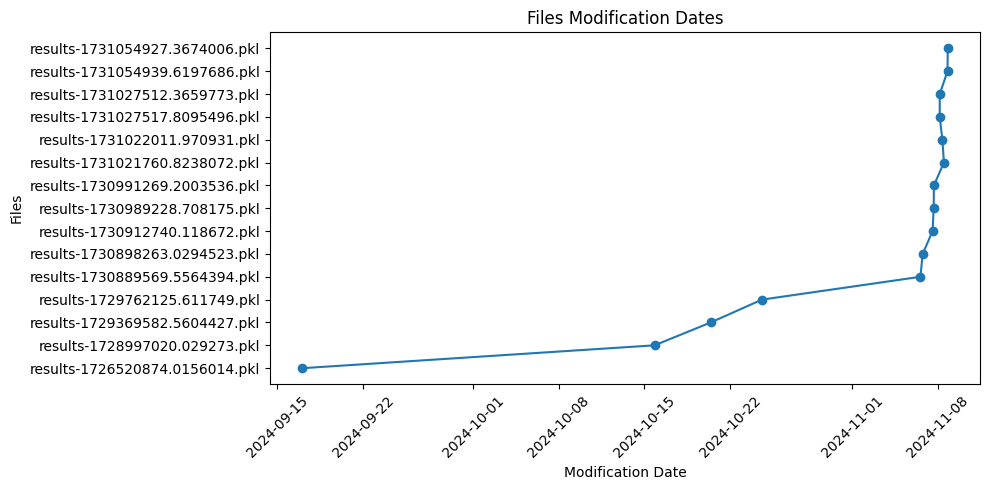

In [7]:
import matplotlib.pyplot as plt
import datetime

# Get modification times
mod_times = [os.path.getmtime(file) for file in files]

# Convert modification times to datetime
mod_dates = [datetime.datetime.fromtimestamp(time) for time in mod_times]

# Plot the dates
plt.figure(figsize=(10, 5))
plt.plot(mod_dates, files, 'o-')
plt.xlabel('Modification Date')
plt.ylabel('Files')
plt.title('Files Modification Dates')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [8]:
latest_files = sorted(zip(mod_dates, files), reverse=True)[:4]
latest_file_names = [file for _, file in latest_files]
print(latest_file_names)

['results-1731054927.3674006.pkl', 'results-1731054939.6197686.pkl', 'results-1731021760.8238072.pkl', 'results-1731022011.970931.pkl']


In [15]:
loaded_pickles = []
for file_name in latest_file_names:
    with open(file_name, 'rb') as file:
        loaded_pickles.append(pickle.load(file))

experiments = sum(loaded_pickles, [])

In [ ]:
len(experiments)

384

In [32]:
import pandas as pd
import numpy as np
import torch

# Initialize an empty dictionary to store the data
data = {}

# Iterate through each experiment in the list
for experiment in experiments:
    for key, value in experiment.items():
        if isinstance(value, torch.Tensor) and len(value.shape)==0:
            if key not in data:
                data[key] = []
            value = value.item()
            data[key].append(value)
        elif isinstance(value, list) or hasattr(value, 'numpy'):
            #if it has one element only, we don't need to follow this process
            if len(value) == 1:
                if key not in data:
                    data[key] = []
                data[key].append(value[0])
                continue
            # Calculate mean and standard deviation if the value is a list
            mean_key = f"{key}_mean"
            std_key = f"{key}_std"
            if mean_key not in data:
                data[mean_key] = []
            if std_key not in data:
                data[std_key] = []
            # Cast value to numpy array from tensor if it's one
            if hasattr(value, 'numpy'):
                value = value.numpy()
            data[mean_key].append(np.mean(value))
            data[std_key].append(np.std(value))
        else:
            # Directly add the value to the dictionary
            if key not in data:
                data[key] = []
            data[key].append(value)

# Create a pandas DataFrame from the dictionary
df_experiments = pd.DataFrame(data)
df_experiments.head()

,dataset,model,alphas_mean,alphas_std,guarantee_level,matching_function,confidence_method,localization_method,classification_method,localization_prediction_set,...,localization_mean_risk,localization_std_risk,classification_mean_risk,classification_std_risk,global_losses_mean,global_losses_std,global_mean_risk,global_std_risk,recall,precision
0,mscoco,detr,0.048333,0.002357,image,hausdorff,box_count_threshold,pixelwise,binary,additive,...,0.051760,0.213395,0.050312,0.211588,0.033381,0.177059,0.033381,0.177063,0.612736,0.982942
1,mscoco,detr,0.048333,0.002357,image,hausdorff,box_count_threshold,pixelwise,binary,additive,...,0.051760,0.213395,0.050312,0.211588,0.033381,0.177059,0.033381,0.177063,0.602225,0.969607
2,mscoco,detr,0.048333,0.002357,image,hausdorff,box_count_threshold,pixelwise,binary,additive,...,0.051760,0.213395,0.050312,0.211588,0.033381,0.177059,0.033381,0.177063,0.612736,0.982942
3,mscoco,detr,0.048333,0.002357,image,hausdorff,box_count_threshold,pixelwise,binary,additive,...,0.051760,0.213395,0.050312,0.211588,0.033381,0.177059,0.033381,0.177063,0.602225,0.969607
4,mscoco,detr,0.048333,0.002357,image,hausdorff,box_count_threshold,pixelwise,binary,multiplicative,...,0.051841,0.213181,0.050312,0.211588,0.030486,0.170882,0.030486,0.170886,0.612736,0.982942


In [18]:
df_experiments.columns

Index(['dataset', 'model', 'alphas_mean', 'alphas_std', 'guarantee_level',
       'matching_function', 'confidence_method', 'localization_method',
       'classification_method', 'localization_prediction_set',
       'classification_prediction_set', 'batch_size', 'optimizer',
       'iou_threshold', 'confidence_set_sizes', 'confidence_losses',
       'localization_set_sizes', 'localization_losses',
       'classification_set_sizes', 'classification_losses',
       'confidence_mean_risk', 'confidence_std_risk', 'localization_mean_risk',
       'localization_std_risk', 'classification_mean_risk',
       'classification_std_risk', 'global_losses', 'global_mean_risk',
       'global_std_risk', 'recall', 'precision'],
      dtype='object')

In [34]:
columns_to_drop = [col for col in df_experiments.columns if 'losses' in col or 'alpha' in col or col in ['optimizer', 'batch_size', 'dataset']]
df_experiments_filtered = df_experiments.drop(columns=columns_to_drop)
df_experiments_filtered.head()

,model,guarantee_level,matching_function,confidence_method,localization_method,classification_method,localization_prediction_set,classification_prediction_set,iou_threshold,confidence_set_sizes_mean,...,confidence_mean_risk,confidence_std_risk,localization_mean_risk,localization_std_risk,classification_mean_risk,classification_std_risk,global_mean_risk,global_std_risk,recall,precision
0,detr,image,hausdorff,box_count_threshold,pixelwise,binary,additive,lac,0.5,41.4044,...,0.056380,0.216113,0.051760,0.213395,0.050312,0.211588,0.033381,0.177063,0.612736,0.982942
1,detr,image,hausdorff,box_count_threshold,pixelwise,binary,additive,lac,0.8,41.4044,...,0.056380,0.216113,0.051760,0.213395,0.050312,0.211588,0.033381,0.177063,0.602225,0.969607
2,detr,image,hausdorff,box_count_threshold,pixelwise,binary,additive,aps,0.5,41.4044,...,0.056380,0.216113,0.051760,0.213395,0.050312,0.211588,0.033381,0.177063,0.612736,0.982942
3,detr,image,hausdorff,box_count_threshold,pixelwise,binary,additive,aps,0.8,41.4044,...,0.056380,0.216113,0.051760,0.213395,0.050312,0.211588,0.033381,0.177063,0.602225,0.969607
4,detr,image,hausdorff,box_count_threshold,pixelwise,binary,multiplicative,lac,0.5,41.4044,...,0.056553,0.215913,0.051841,0.213181,0.050312,0.211588,0.030486,0.170886,0.612736,0.982942


In [35]:
df_experiments_filtered.to_csv('experiments_filtered.csv', index=False)